<a href="https://colab.research.google.com/github/dajebbar/Flowers-Recognition-with-PyTorch/blob/main/Flowers_Recognition_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download the dataset from kaggle
Using `opendatasets` and download the dataset [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition)

In [2]:
!pip install opendatasets --upgrade --quiet

In [3]:
import opendatasets as od

url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

od.download(url)

  0%|          | 0.00/450M [00:00<?, ?B/s]

100%|██████████| 450M/450M [00:16<00:00, 29.4MB/s]


In [4]:
import os

data_dir = './flowers-recognition/flowers'

os.listdir(data_dir)

['sunflower', 'dandelion', 'rose', 'tulip', 'flowers', 'daisy']

In [5]:
import shutil

shutil.rmtree(data_dir + '/flowers')

In [6]:
os.listdir(data_dir)

['sunflower', 'dandelion', 'rose', 'tulip', 'daisy']

In [7]:
for cls in os.listdir(data_dir):
  print(f"{cls}: {len(os.listdir(data_dir + '/' + cls))}")

sunflower: 734
dandelion: 1055
rose: 784
tulip: 984
daisy: 769


## Import the dataset into PyTorch

Use the `ImageFolder` class from `torchvision`.

In [8]:
from torchvision.datasets import ImageFolder

In [9]:
dataset = ImageFolder(data_dir)

In [10]:
len(dataset)

4323

In [11]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7F10A1E61E10>, 0)

In [12]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [13]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

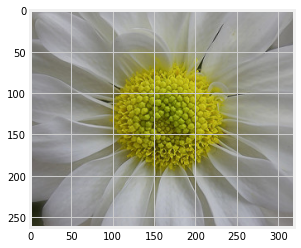

In [14]:
img, _ = dataset[0]
plt.imshow(img)

In [15]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64),
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

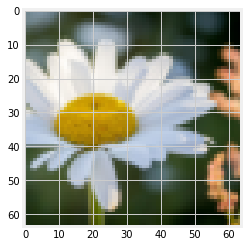

In [16]:
img, _ = dataset[170]
plt.imshow(img.permute(1,2,0))

In [17]:
val_pct = .1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(3891, 432)

In [18]:
from torch.utils.data import random_split

train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(3891, 432)

In [19]:
from torch.utils.data import  DataLoader

batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True,
                      num_workers=2, pin_memory=True)

val_dl = DataLoader(val_ds, batch_size,
                    num_workers=2, pin_memory=True)

In [20]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

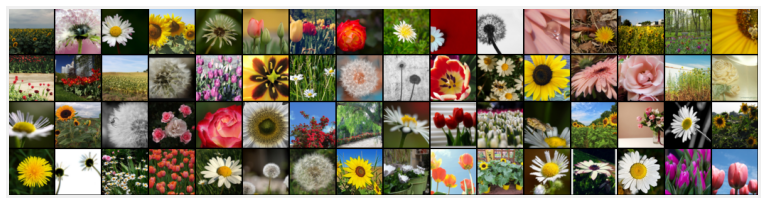

In [21]:
show_batch(train_dl)

## GPU Utilities

In [22]:
import torch

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [23]:
device = get_default_device()
device

device(type='cuda')

In [24]:
images, labels = dataset[0]

In [25]:
images.device

device(type='cpu')

In [26]:
img_gpu = to_device(images, device)
img_gpu.device

device(type='cuda', index=0)

In [27]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Model & Training Utilities

In [35]:
import torch.nn as nn
import torch.nn.functional as F


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [29]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

## Model

In [30]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [31]:
model = to_device(ResNet9(3, len(dataset.classes)), device)

model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [32]:
model.conv1[0].weight.device

device(type='cuda', index=0)

Pass one batch of input tensor through the model

In [34]:
torch.cuda.empty_cache()

for batch in train_dl:
  images, labels = batch
  print('images.shape ', images.shape)
  print('images.device ', images.device)

  preds = model(images)

  print('preds.shape ', preds.shape)
  print('preds ', preds)
  break

images.shape  torch.Size([64, 3, 64, 64])
images.device  cuda:0
preds.shape  torch.Size([64, 5])
preds  tensor([[ 3.0755e+00, -9.1581e-01,  3.8998e+00,  8.8821e-01, -2.1137e-01],
        [ 9.0177e-01, -1.6238e+00,  4.0635e+00,  3.2690e+00,  2.7103e-01],
        [ 2.4164e+00, -2.3647e+00,  1.0122e+00,  3.2611e-01,  3.2459e+00],
        [ 4.8870e-01, -2.0513e-01,  1.1012e+00,  2.6596e-01, -1.7875e+00],
        [ 2.6108e+00, -3.3583e-02,  1.1115e+00,  1.3435e-01,  5.1417e-01],
        [ 7.2929e-01,  1.4281e+00,  4.5421e+00,  2.4833e+00,  1.1504e+00],
        [ 3.0843e+00,  1.0349e-01,  1.8275e+00, -1.6496e-01, -5.4726e-01],
        [ 1.1857e+00, -1.1605e+00,  4.7818e+00,  2.3367e-01,  3.9608e-01],
        [ 2.6126e+00,  6.5848e-01,  5.0139e+00,  3.4669e+00, -9.3326e-01],
        [ 1.9020e-01, -1.3910e+00,  3.5234e+00, -4.0560e-01,  1.7151e+00],
        [ 2.1469e+00, -2.2195e+00,  5.1419e+00,  5.1520e-01, -1.3939e+00],
        [ 3.9023e+00, -1.9398e+00,  1.1586e+00,  2.8323e+00, -3.5436e+0

## Training

In [36]:
history = [evaluate(model, val_dl)]
history 

[{'val_acc': 0.1949404776096344, 'val_loss': 2.6681721210479736}]

In [37]:
history += fit(5, 0.001,model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.3738, val_loss: 0.9228, val_acc: 0.6391
Epoch [1], train_loss: 0.9555, val_loss: 0.9702, val_acc: 0.6034
Epoch [2], train_loss: 0.8634, val_loss: 0.8820, val_acc: 0.6912
Epoch [3], train_loss: 0.8427, val_loss: 0.8930, val_acc: 0.6540
Epoch [4], train_loss: 0.6334, val_loss: 0.7122, val_acc: 0.7433


In [38]:
history += fit(5, 0.001,model, train_dl, val_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.7738, val_loss: 0.8215, val_acc: 0.6994
Epoch [1], train_loss: 0.6662, val_loss: 0.7085, val_acc: 0.7351
Epoch [2], train_loss: 0.5693, val_loss: 0.7586, val_acc: 0.7500
Epoch [3], train_loss: 0.5008, val_loss: 0.7026, val_acc: 0.7812
Epoch [4], train_loss: 0.5024, val_loss: 0.6124, val_acc: 0.7872
